In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 36s 465ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798 - val_loss: 0.1416 - val_root_mean_squared_error: 0.3763
Epoch 2/50
53/53 [==============================] - 22s 430ms/step - loss: 0.1003 - root_mean_squared_error: 0.3167 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2765
Epoch 3/50
53/53 [==============================] - 23s 447ms/step - loss: 0.0618 - root_mean_squared_error: 0.2485 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 4/50
53/53 [==============================] - 23s 443ms/step - loss: 0.0443 - root_mean_squared_error: 0.2106 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1858
Epoch 5/50
53/53 [==============================] - 23s 438ms/step - loss: 0.0295 - root_mean_squared_error: 0.1718 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 6/50
53/53 [==============================] - 22s 426ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456 - val_loss: 0.0113 

Epoch 34/50
53/53 [==============================] - 2s 46ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 35/50
53/53 [==============================] - 3s 48ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 36/50
53/53 [==============================] - 3s 52ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 37/50
53/53 [==============================] - 3s 49ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 38/50
53/53 [==============================] - 3s 48ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 39/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0035 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.286582096417744 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

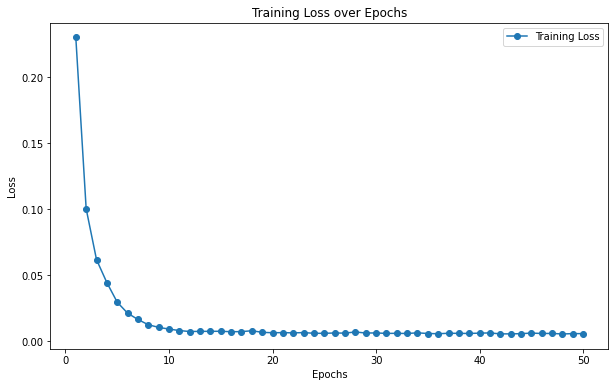

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

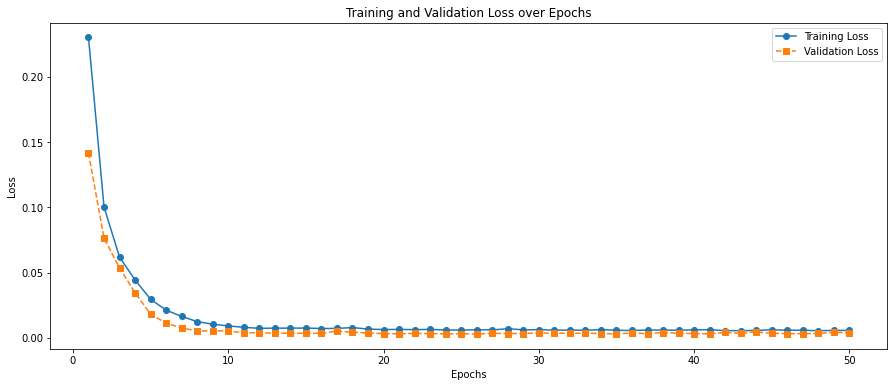

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.052355228504233076
MAE : 0.0402144596244785


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.038316e+06,974461.347
1,1.190754e+06,1181121.087
2,1.207246e+06,1236299.254
3,1.075209e+06,1036981.003
4,8.653805e+05,847489.150
5,5.538243e+05,619129.338
6,2.071176e+05,195688.491
7,2.326723e+04,36670.811
8,-5.394591e+04,31777.310
9,5.237596e+04,82762.022


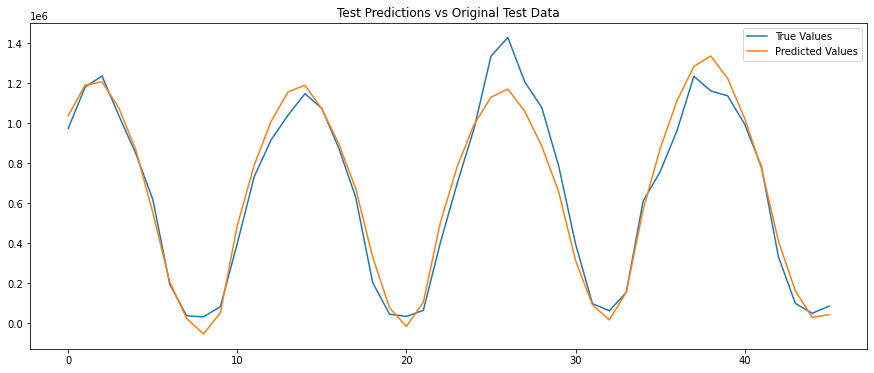

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 21ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

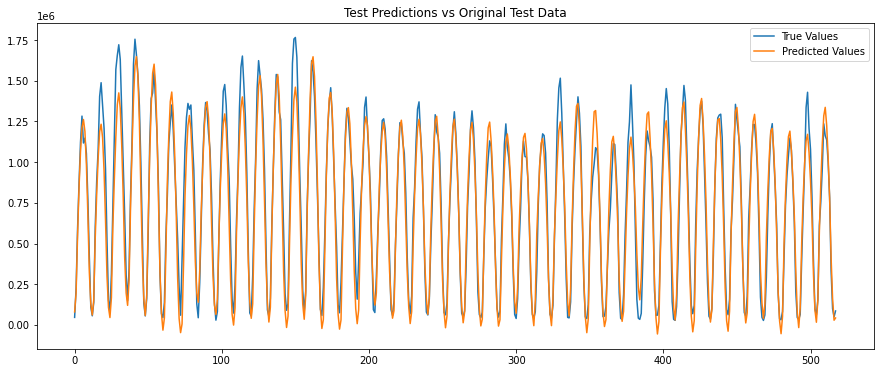

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()